In [1]:
#Importing the packages
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import nltk
from transformers import GPT2Tokenizer, GPT2Model
import spacy
import torch
import re,string
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword=set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")

df = pd.read_csv("C:\\Users\\Admin\\Downloads\\twitter_data.csv")

print(df.shape)

df.head(5)

(24783, 7)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [2]:
nlp = spacy.load("en_core_web_lg", disable=["tagger"])

In [3]:
df["labels"] = df['class'].map({0: "Hate Speech", 1: "Offensive Speech", 2: "No Hate and Offensive Speech"})
df = df[["tweet", "labels"]]

In [4]:
 def preprocess(text):
        test_list = text.split()
        text = ""
        for word in test_list:
            if word.endswith("ing"):
                word=word[:-3]
            text+=word
            text+=" "
        doc = nlp(text)
        filtered_tokens = []
        
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            filtered_tokens.append(token.lemma_)
            
        return " ".join(filtered_tokens)

In [5]:
df["tweet_new"] = df.tweet.apply(preprocess)

C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [6]:
df.head()

,tweet,labels,tweet_new
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive Speech,rt @mayasolovely woman complain clean house am...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Speech,rt @mleew17 boy dats cold tyga dwn bad cuffin ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Speech,rt @urkindofbrand dawg rt @80sbaby4life fuck b...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Speech,rt @c_g_anderson @viva_based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Speech,rt @shenikaroberts shit hear true faker bitch ...


In [7]:
def clean(text):
    text = str (text). lower()
    text = re. sub('[.?]', '', text)
    text = re. sub('https?://\S+|www.\S+', '', text)
    text = re. sub('<.?>+', '', text)
    text = re. sub('[%s]' % re. escape(string. punctuation), '', text)
    text = re. sub('\n', '', text)
    text = re. sub('\w\d\w', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ". join(text)
    text = [stemmer. stem(word) for word in text. split(' ')]
    text=" ". join(text)
    return text

In [8]:
df["tweet_new"] = df.tweet_new.apply(clean)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
x = np. array(df["tweet_new"])
y = np. array(df["labels"])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [10]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained(model_name)

In [11]:
def sentence_to_gpt_embeddings(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()

In [12]:
X_train_gpt = [sentence_to_gpt_embeddings(sentence, tokenizer, model) for sentence in X_train]

In [13]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split data into training and testing
X_train_gpt, X_test_gpt, y_train_enc, y_test_enc = train_test_split(X_train_gpt, y_train_encoded, test_size=0.2, random_state=42)

In [14]:
model1 = DecisionTreeClassifier()
#Training the model
model1.fit(X_train_gpt,y_train_enc)
#Testing the model
y_pred = model1.predict (X_test_gpt)
#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

'''# Preprocess and clean the new input
new_string = "Your new input string"
new_string = preprocess(new_string)

# Convert the new input to GPT-3 embeddings
new_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)

# Predict the label
predicted_label_encoded = model1.predict(new_string_embedding)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)'''

0.7046070460704607


'# Preprocess and clean the new input\nnew_string = "Your new input string"\nnew_string = preprocess(new_string)\n\n# Convert the new input to GPT-3 embeddings\nnew_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)\n\n# Predict the label\npredicted_label_encoded = model1.predict(new_string_embedding)\npredicted_label = label_encoder.inverse_transform(predicted_label_encoded)\n\nprint("Predicted Label:", predicted_label)'

Decision Tree Accuracy: 0.7046070460704607
Decision Tree F1 Score: 0.7100367973409496
Decision Tree Precision: 0.7157215113702801
Decision Tree Recall: 0.7046070460704607
Decision Tree AUC Scores per class: 0.6217314709508374
Decision Tree Confusion Matrix:
[[  20   38  136]
 [  51  217  285]
 [ 171  300 2103]]


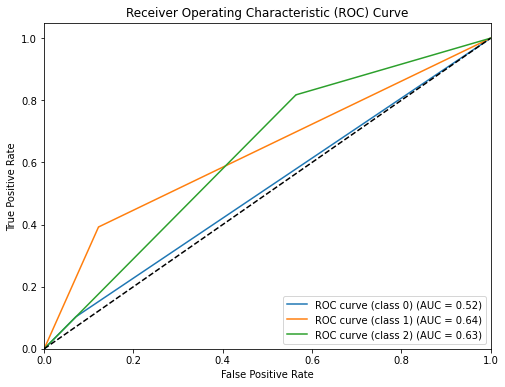

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
dt_accuracy = accuracy_score(y_test_enc, model1.predict(X_test_gpt))
print("Decision Tree Accuracy:", dt_accuracy)

# Calculate F1 score
dt_f1_score = f1_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Decision Tree F1 Score:", dt_f1_score)

# Calculate precision
dt_precision = precision_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Decision Tree Precision:", dt_precision)

# Calculate recall
dt_recall = recall_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Decision Tree Recall:", dt_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = model1.predict_proba(X_test_gpt)
dt_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Decision Tree AUC Scores per class:", dt_auc_scores)

# Calculate confusion matrix
dt_conf_matrix = confusion_matrix(y_test_enc, model1.predict(X_test_gpt))
print("Decision Tree Confusion Matrix:")
print(dt_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()
model1.fit(X_train_gpt,y_train_enc)
y_pred = model1.predict(X_test_gpt)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_enc,y_pred)

print("Logistic Regression Accuracy:", accuracy)

'''# Preprocess and clean the new input
new_string = "Your new input string"
new_string = preprocess(new_string)

# Convert the new input to GPT-2 embeddings
new_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)

# Predict the label
predicted_label_encoded = model1.predict(new_string_embedding)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)'''

Logistic Regression Accuracy: 0.8325805480277025


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'# Preprocess and clean the new input\nnew_string = "Your new input string"\nnew_string = preprocess(new_string)\n\n# Convert the new input to GPT-2 embeddings\nnew_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)\n\n# Predict the label\npredicted_label_encoded = model1.predict(new_string_embedding)\npredicted_label = label_encoder.inverse_transform(predicted_label_encoded)\n\nprint("Predicted Label:", predicted_label)'

Logistic Regression Accuracy: 0.8325805480277025
Logistic Regression F1 Score: 0.8055260951641088
Logistic Regression Precision: 0.8049994725493484
Logistic Regression Recall: 0.8325805480277025
Logistic Regression AUC Scores per class: 0.8493614547399909
Logistic Regression Confusion Matrix:
[[   4   38  152]
 [   1  319  233]
 [   4  128 2442]]


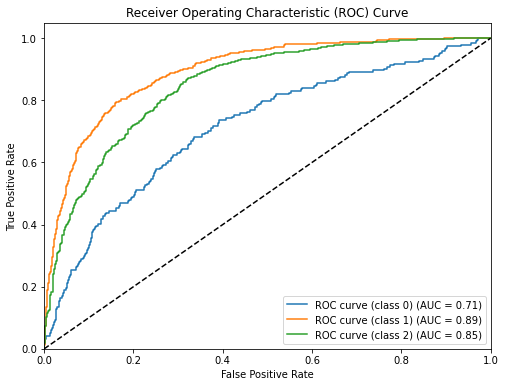

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
lr_accuracy = accuracy_score(y_test_enc, model1.predict(X_test_gpt))
print("Logistic Regression Accuracy:", lr_accuracy)

# Calculate F1 score
lr_f1_score = f1_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Logistic Regression F1 Score:", lr_f1_score)

# Calculate precision
lr_precision = precision_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Logistic Regression Precision:", lr_precision)

# Calculate recall
lr_recall = recall_score(y_test_enc, model1.predict(X_test_gpt), average='weighted')
print("Logistic Regression Recall:", lr_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = model1.predict_proba(X_test_gpt)
lr_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Logistic Regression AUC Scores per class:", lr_auc_scores)

# Calculate confusion matrix
lr_conf_matrix = confusion_matrix(y_test_enc, model1.predict(X_test_gpt))
print("Logistic Regression Confusion Matrix:")
print(lr_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_gpt, y_train_enc)

#Testing the model
y_pred = clf.predict (X_test_gpt)

#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

# Preprocess and clean the new input
new_string = "Your"
new_string = preprocess(new_string)

# Convert the new input to GPT-3 embeddings
new_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)

# Predict the label
predicted_label_encoded = clf.predict(new_string_embedding)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)

C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


0.7750677506775068


RuntimeError: cannot reshape tensor of 0 elements into shape [-1, 0] because the unspecified dimension size -1 can be any value and is ambiguous

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Model building
model1 = RandomForestClassifier()
#Training the model
model1.fit(X_train_gpt,y_train_enc)
#Testing the model
y_pred = model1.predict (X_test_gpt)
#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

# Preprocess and clean the new input
new_string = "Your"
new_string = preprocess(new_string)

# Convert the new input to GPT-3 embeddings
new_string_embedding = sentence_to_gpt_embeddings(new_string, tokenizer, model).reshape(1, -1)

# Predict the label
predicted_label_encoded = model1.predict(new_string_embedding)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize individual models
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
svm_model = SVC(kernel='linear', probability=True)  # Enable probability estimation for SVM

# Define the ensemble of models
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', rf_model),
    ('svm', svm_model)
], voting='soft')  # Use soft voting for probability averaging

# Training the ensemble model
ensemble_model.fit(X_train_gpt, y_train_enc)

# Testing the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test_gpt)

# Accuracy Score of ensemble model
print("Ensemble Accuracy Score:", accuracy_score(y_test_enc, y_pred_ensemble))

In [ ]:
# Get input from the user
user_input = input("Enter the text you want to classify: ")

# Preprocess the user input
user_input_processed = preprocess(user_input)

user_input_vectorized = sentence_to_gpt_embeddings(user_input_vectorized, tokenizer, model).reshape(1, -1)

# Make prediction using the ensemble model
prediction = ensemble_model.predict(user_input_vectorized)

# Print the predicted label
print("Predicted label:", prediction)